In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.circuit import ParameterVector
from qiskit.quantum_info.states.random import random_statevector, random_unitary
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.utils import get_subsystem_density_matrix
from qiskit.aqua import aqua_globals
from qiskit.extensions.quantum_initializer.uc import UCGate
from scipy.special import rel_entr
from qiskit.extensions import CXGate
from qiskit.providers.aer.extensions.snapshot_statevector import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# setup qiskit.chemistry logging
import logging
from qiskit.chemistry import set_qiskit_chemistry_logging
set_qiskit_chemistry_logging(logging.ERROR)
# choose among DEBUG, INFO, WARNING, ERROR, CRITICAL and NOTSET # choose among DEBUG, INFO, WARNING, ERROR, CRITICAL and NOTSET

In [2]:
backend = Aer.get_backend("qasm_simulator")
print(backend)

#Set the seed for reproducible results
aqua_globals.random_seed = 100
seed_simulator = 100
seed_transpiler=100
np.random.seed(100)

qasm_simulator


In [3]:
def haar_distribution():
    flist = []
    for m in range(2000):
        a = random_statevector(4)
        b = random_statevector(4)
        flist.append(state_fidelity(a, b))
    return flist

In [4]:
#Determine expressibility for CZ and CX gates #
def quantum_state_preparation(parameters):
        circuit = QuantumCircuit(1)
        #circuit.id(0)
        circuit.h(0)
        circuit.rz(parameters[0], 0)
        circuit.rx(parameters[1], 0)
        circuit.snapshot_statevector('final')
        return circuit

def get_distribution():
    cfidelityList = []
    for m in range(5000):
        qstatelist = []
        for i in range(2):
            # Obtain a quantum circuit instance from the paramters
           # params = np.random.random(2)*2*np.pi #0 to 2pi, below is replacement for uniform sampling
            params = np.random.random(2)
            params[0] = np.arccos(params[0]*2 -1)
            if np.random.random(1) < 0.5:
                 params[0] += np.pi
            params[1] *=  2 * np.pi
            circ = quantum_state_preparation(params)
            result = execute(circ, backend, seed_simulator=seed_simulator, seed_transpiler=seed_transpiler).result()
            outputstate = result.data(0)['snapshots']['statevector']['final']
            #statevector = np.concatenate(outputstate)
            qstatelist.append(outputstate[0])
        cfidelityList.append(state_fidelity(qstatelist[0], qstatelist[1]))
    print(circ.draw())
    return cfidelityList

In [5]:
#Compute KL divergence between distributions of state fidelities
def kl_divergence(p):
    N= 2 #1<<num_qubits
    num_bins = 75
    bin_width = 1/num_bins
    bin_edges = np.linspace(0,1,num_bins+1)
    
    chist, _ =  np.histogram(np.array(p), bins=bin_edges, density= True)
    fhist = np.array([(N-1)*(1-F)**(N-2) for F in bin_edges[:-1]])
    
    kl_pq = np.sum(rel_entr(chist*bin_width, fhist/sum(fhist))) #fhist*bin_width))
    print('KL(P || Q): %.3f ' % kl_pq)
    return kl_pq

Figure(314.126x84.28)
KL(P || Q): 0.007 


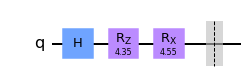

In [6]:
#hlist = haar_distribution()
#circuit B experiment
num_qubits = 1
cfidelityList = get_distribution()
kl = kl_divergence(cfidelityList)

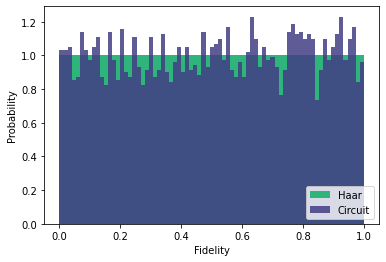

In [9]:
#Plot the distribution - review before running
N=2
num_bins = 75
bin_width = 1/num_bins
bin_edges = np.linspace(0,1,num_bins+1)
#Sampling Haar measure
#flist =[]
#for i in range(2000):
#     a=random_statevector(4)
#     b=random_statevector(4)
#     flist.append(state_fidelity(a, b))
#fhist, fbin_edges =  np.histogram(np.array(flist), bins=cbin_edges, density= True)

chist, _ =  np.histogram(np.array(cfidelityList), bins=bin_edges, density= True)
#analytical haar measure
fhist = np.array([(N-1)*(1-F)**(N-2) for F in bin_edges[:-1]])

# Get some pastel shades for the colors
# cmaps['Perceptually Uniform Sequential'] = [
#             'viridis', 'plasma', 'inferno', 'magma', 'cividis']

data_color = [180.,650.,450.,1000.]
#data_color = [180.,570.,450.,900.]
data_color = [x / max(data_color) for x in data_color]
#fig, ax = plt.subplots(figsize=(15, 4))
my_cmap = plt.cm.get_cmap('viridis')
colors = my_cmap(data_color)
plt.bar(bin_edges[:-1],fhist,align="edge",width=bin_width,color=colors[1],label="Haar")
plt.bar(bin_edges[:-1],chist,align="edge",width=bin_width,color=colors[0],alpha = 0.85,label="Circuit")
plt.xlabel('Fidelity')
plt.ylabel('Probability')
plt.legend(loc=4)

#_ = plt.hist(np.array(cfidelityList), bins=10,density=True)  # arguments are passed to np.histogram
#plt.title("Histogram with 'auto' bins")
 

#_ = plt.hist(np.array(flist), bins=10,density=True)
#_=plt.plot(np.linspace(0,1,100),[(N-1)*(1-F)**(N-2) for F in np.linspace(0,1,100)])
#plt.show()